In [1]:
import os
import argparse

import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

from src.model import MemNetFC
from src.dataset import MNIST_Mem_Dataset, flattenMNIST
from src.train import train_model, test_acc

# Run Parameters

In [2]:
input_size = 784
output_size = 10
hidden_layers = [1024, 1024, 1024]
percentage_to_memorize = 0.1  # the percent of data taken from the training set which will be memorized
batch_size = 128
epochs = 50

save_path = './models/mnist_example.ckpt'

## Dataset Defnition

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fltmnist=flattenMNIST()

# For the primary task:
train_dataset =  datasets.MNIST('./data/', train=True, download=True,
                             transform = transforms.Compose([
                              transforms.ToTensor(), fltmnist
                             ]))
train_loader_cls = DataLoader(train_dataset, pin_memory=True,
                                      batch_size=batch_size, shuffle=True)

# For evaluating the primary task:
test_dataset = datasets.MNIST('./data/', train=False, download=True,
                             transform = transforms.Compose([
                              transforms.ToTensor(),fltmnist
                             ]))
test_loader_cls = DataLoader(test_dataset, pin_memory=True,
                                      batch_size=batch_size, shuffle=True)

# For the secondary task:
## Here we will use the provided MNIST Dataset for memorization (based on MNIST train data)
mem_dataset = MNIST_Mem_Dataset(percentage_to_memorize, device)
train_loader_mem = DataLoader(mem_dataset,
  batch_size=batch_size, shuffle=True)


## Model Defnition

In [4]:
# build the model
model = MemNetFC(input_size = input_size,
               output_size = output_size,
               hidden_layers = hidden_layers).to(device)

## Training

In [5]:
# set the optimizers for the primary and secondary tasks
optimizer_cls = optim.AdamW(model.parameters(), lr=1e-4)
optimizer_mem = optim.AdamW(model.parameters(), lr=1e-3)

# set the loss functions for the primary and secondary tasks
loss_cls = nn.CrossEntropyLoss()
loss_mem = nn.MSELoss()

In [6]:
train_model(model, train_loader_cls, train_loader_mem,
    optimizer_cls, optimizer_mem, loss_cls, loss_mem, epochs, save_path, device)

epoch : 1/50, loss_c = 0.583620, loss_r = 0.056132
epoch : 2/50, loss_c = 0.291203, loss_r = 0.053988
epoch : 3/50, loss_c = 0.217972, loss_r = 0.052839
epoch : 4/50, loss_c = 0.181541, loss_r = 0.050750
epoch : 5/50, loss_c = 0.152314, loss_r = 0.046884
epoch : 6/50, loss_c = 0.134216, loss_r = 0.041292
epoch : 7/50, loss_c = 0.119099, loss_r = 0.035239
epoch : 8/50, loss_c = 0.106043, loss_r = 0.029939
epoch : 9/50, loss_c = 0.093468, loss_r = 0.025595
epoch : 10/50, loss_c = 0.082154, loss_r = 0.022401
epoch : 11/50, loss_c = 0.072865, loss_r = 0.019895
epoch : 12/50, loss_c = 0.068115, loss_r = 0.018065
epoch : 13/50, loss_c = 0.059043, loss_r = 0.016582
epoch : 14/50, loss_c = 0.053403, loss_r = 0.015456
epoch : 15/50, loss_c = 0.048133, loss_r = 0.014562
epoch : 16/50, loss_c = 0.043226, loss_r = 0.013860
epoch : 17/50, loss_c = 0.037911, loss_r = 0.013203
epoch : 18/50, loss_c = 0.036076, loss_r = 0.012663
epoch : 19/50, loss_c = 0.032159, loss_r = 0.012197
epoch : 20/50, loss_c

## Test Classification

In [7]:
state = torch.load(save_path)
model.load_state_dict(state['net'])

<All keys matched successfully>

In [9]:
test_acc(model, test_loader_cls, device)

tensor(0.9747, device='cuda:0')

## Memorized Images

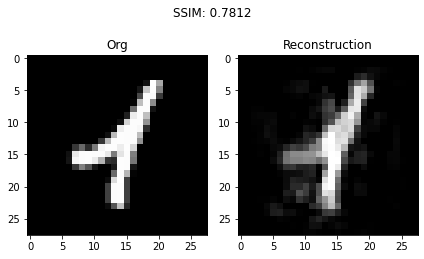

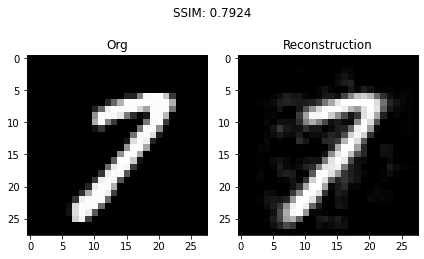

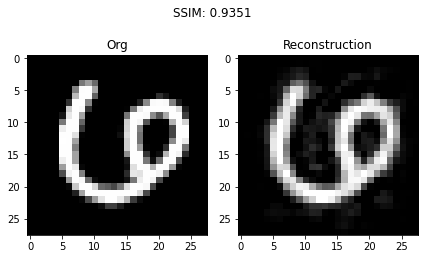

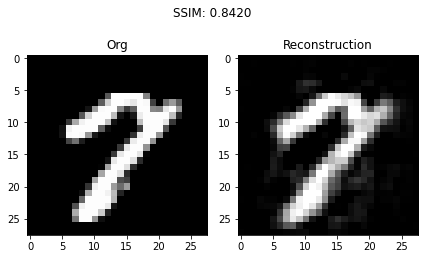

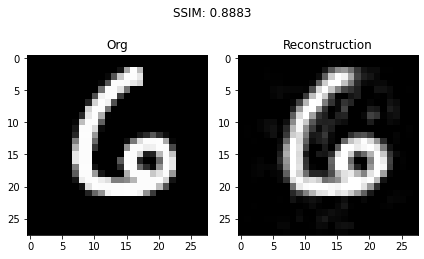

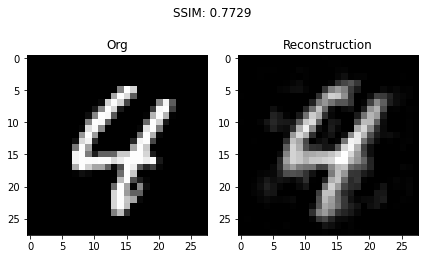

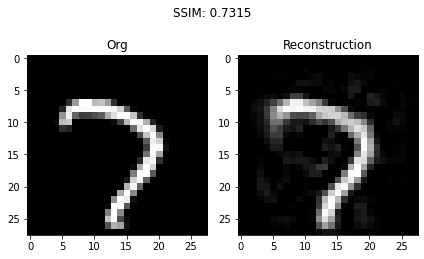

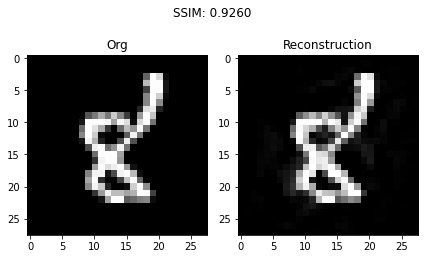

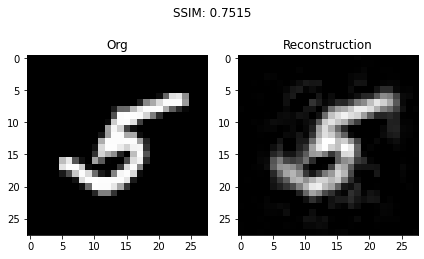

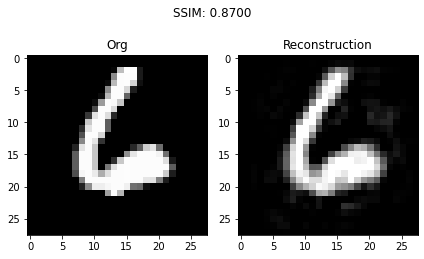

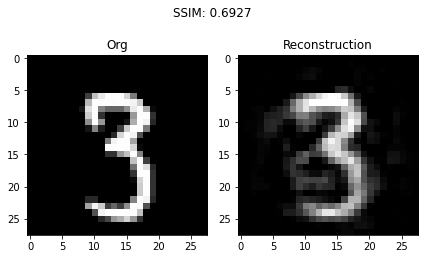

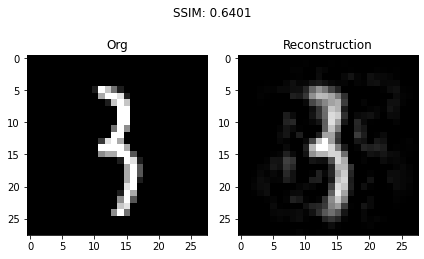

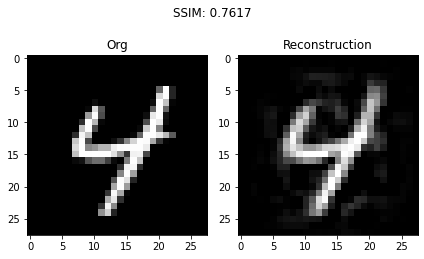

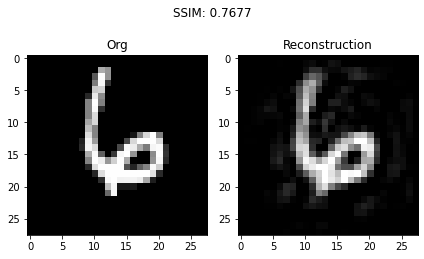

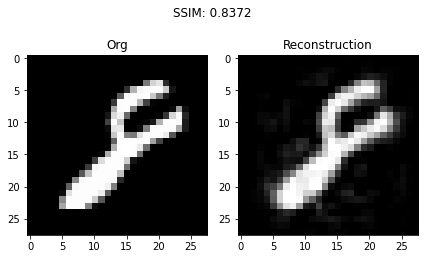

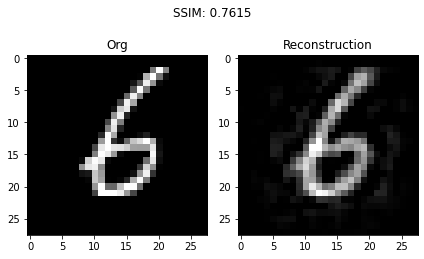

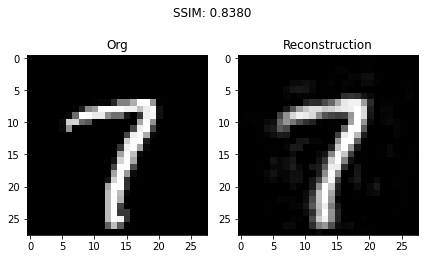

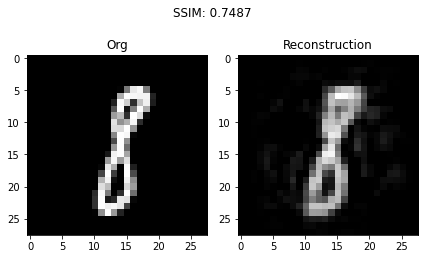

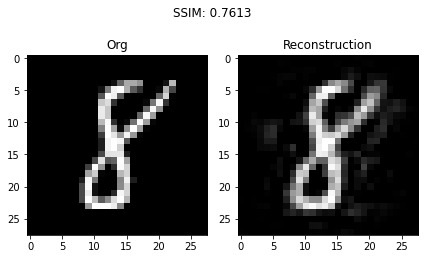

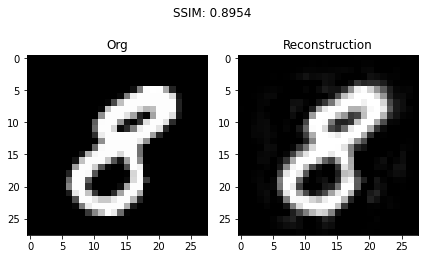

In [10]:
model.eval()
max_plot = 20
for idx, (code, _, img) in enumerate(mem_dataset):
    with torch.no_grad():
        rec_image = model.forward_transposed(code.reshape(1, 10))
        rec_image = torch.clamp(rec_image.view(28, 28), 0, 1).cpu()
        img = img.view(28, 28).cpu()
        ssim_metric = ssim(img.numpy(),
                   rec_image.numpy(),
                   multichannel=False)
        
        fig, ax = plt.subplots(ncols=2, tight_layout=True)
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Org')
        ax[1].imshow(rec_image, cmap='gray')
        ax[1].set_title('Reconstruction')
        plt.suptitle('SSIM: {:.4f}'.format(ssim_metric))
        plt.show()
        if idx == max_plot-1:
            break
        